# Week 11: Networks 3 (epidemiology)


While researchers have been modeling the spread of diseases and information for many years, the COVID-19 pandemic playing out right now puts a new emphasis on the importance of being able to model (and thus predict) how diseases propagate through populations. So how do you most effectively model the spread of a disease? There are many^ ways, and all of them (at least the useful ones) involves networks. In this notebook you will get your hands on a couple different modeling approaches. Specifically:

* Spreading processes on static networks
* Spreading processes on temporal networks
* Metapopulation models

**Questions**: Outside of class, use [issue on GitHub](https://github.com/abjer/tsds/issues) for asking questions.

## Imports

In [6]:
%matplotlib inline
import matplotlib.pylab as plt
import networkx as nx
import netwulf as nw
import numpy as np

## Exercises

In a *contact network* nodes are people and links represent interactions that can happen between people. You can use such a network as a *substrate* for simulating the spreading of "something". Spreading of what? That's up to you. It can be a disease, a behavior, a piece of information, anything you can imagine people may pass along. There's a whole subfield of Network Science which deals with this, but the fundamental idea is actually quite simple:

> Nodes that are connected can transmit this "something" with a probability. Each timestep of the simulation is an opportunity for the "something" to spread.

You can then make this more nuanced by adding extra criteria for transmission. For disease modeling these can e.g. be that nodes can only be infected after multiple exposures or if multiple neighbors are infected, that they can be cured and become resistant/susceptible with some probability, that they may die and exit the simulation creating a void in the network, that becoming infected makes them change their links, that godzilla walks in and eats everyone—the possibilities are endless and you decide which rules exist in the simulation universe.

Generally speaking, there are four major classes of so-called "compartmental models" in network epidemiology:
* *Susceptible-Infected (SI)*: Nodes are susceptible at start, and once they are infected they never recover. This models spreading of unforgetable information, or diseases that people get and pass on, and never recover from (like HIV, herpes, etc.).
* *Susceptible-Infected-Susceptible (SIS)*: Nodes are susceptible, then get infected and stay infected for some time, then get susceptible again, an the cycle continues. This could model things like the flu which comes and goes and you get and recover from over and over again.
* *Susceptible-Infected-Resistant (SIR)*: Nodes become infected and after some time they gain resistance so that they can niether become infected nor spread disease/information further. Once they are resistant they are essentially "removed" from the network, so this type of model works for diseases where people recover and gain resistance as well as ones that kill people, as niether type of person can transmit (measles, chickenpox but also rabies, Creutzfeldt–Jakob disease, etc.).
* *Susceptible-Infected-Resistant-Susceptible (SIRS)*: Probably self-explanatory if you understood the above.

The idea that drives the "compartmenal" modeling approach is that within a population you can assign each
individual to a compartment based on their "state" (infected, susceptible, etc.). When you start the simulation,
individuals then flow between compartments with specific flow rates.

![img](https://upload.wikimedia.org/wikipedia/commons/9/93/SIR_Flow_Diagram.svg)

This then allows us to describe the flow of individuals between compartments (and thus the spreading of the disease)
using differential equations. For example in the simple SIR model shown above, the dynamics can be described with
three differential equations (one for each compartment). They each tell us how fast the population in the corresponding
compartment it changing:

$$\frac{dS}{dt} = -\beta SI$$

$$\frac{dI}{dt} = \beta SI - \gamma I$$

$$\frac{dR}{dt} = \gamma I$$

So at a given point in time how many people are leaving the susceptible compartment and entering the Infected compartment?
Well that's simply the the number of susceptible $S$ times the number of infected $I$ multipled with some disease-specific constant $\beta$.

And what's the growth in the number of infected? Easy! It's just the number of people coming in from the susceptible compartment $\beta SI$ minus all the people leaving for the "Recovered" compartment $\gamma I$, where gamma is some constant that describs how fast people recover.

And the rate at which people enter the recovered state? If you understood the above you can explain this to yourself.

**That's it!**. That's how all compartmental models work!

> **Ex. 11.1.1**: But as I wrote above there are many different types of compartmental models. Write down the rate equations for the SIS model:
>
>![img](https://upload.wikimedia.org/wikipedia/commons/c/cb/SIS_compartment_model.svg)
>
> Follow the reasoning in the example for the SIR model above. Answer the following:
* how many equations you need if there are two compartments.
* What specifically does each equation describe?
* What do $\beta$ and $\gamma$ intuitively describe? What can you say about a disease with a really big $\gamma$? Or a really small $\gamma$? How about big or small $\beta$?

**Answer to 11.1.1**
- We will need two equations:

$$\frac{dS}{dt} = -\beta SI + \gamma I$$

$$\frac{dI}{dt} = \beta SI - \gamma I$$

- The first eqation desribes *the growth in the number of infected*, and the second, *the growth in the number of people in the susceptible compartment*
- $\beta$ desribes the rate at which people get infected (a disease-specific constant - could be how contagious the diease is)
- $\gamma$ desribes the rate at which people recover from the diease and reenters the susceptible compartment
    - High $\beta$ means the diease is very contagious and high $\gamma$ means it will take a very long time to recover from the diease

> **Ex. 11.1.2** (optional): If you really understood the above, you should have no trouble writing down the equations for a SIRS
model. Go ahead and try. Hint: You will need to introduce a new constant that describes the rate at which people move from R to S.

> **Ex. 11.1.3**: Professor of physics and mathematic and all around cool guy, Dirk Brockmann,
makes interactive articles called *Explorables* that introduce ideas in Complexity science. Read/play with
[his explorable](http://www.complexity-explorables.org/explorables/neighbors/) on targeted vaccination to mitigate epidemic spreading in the real world and answer the
following questions:
> 1. In the BA network, roughly what percentage of the population do you have to vaccinate with **strategy A** to only get around 10
infected individuals? What about **startegy B** and **strategy C**?
> 2. **strategy A** and **strategy C** are both entirely random, but one is much more effective than the other. Explain
why. What clever idea is **strategy C** employing?
> 3. Why is this effect larger in the BA network than in the ER network?

> **Ex. 11.1.4**: Choose one of these two explorables ([1](http://www.complexity-explorables.org/explorables/herd/) or [2](http://www.complexity-explorables.org/explorables/epidemonic/)) read/play with and understand it, and explain in your own words what phenomenon it communicates.

> **Ex. 11.1.5**: The simplest compartmental model is the *SI* model. Below I have implemented a simulation of such a model.
You can see in line 5 that I initialize all nodes in the *S* compartment, but after running, all nodes are in the *I* compartment.
Does this make sense to you?
1. Comment the code abundantly, explaining what's happing at each step.
2. Adapt the code and make a plot of the fraction of infected over time. You may have to restart it a couple of time to make sure patient 0 is someone connected to the rest of the population.
3. Extend the code such after a variable number of timesteps `T_I` infected nodes become susceptible again. Set `T_I = 10` to begin with and plot the fraction of infected over time for 200 timesteps. Does the result make sense? Comment on what you see.

In [3]:
G = nx.connected_caveman_graph(10, 5)
_ = nw.visualize(G) # Uncomment if you want to have a look at the network

In [11]:
p_I = 0.1 # We set the probability of catching the diease
n_iter = 200 # The number of iterations

I = set() # No one is infected to begin with so the set is empty 
S = set(G.nodes()) # susceptible is set as the nodes from the network G

patient0 = np.random.choice(list(S)) # patient 0 is randomly drawn from the susceptible compartment

I.add(patient0) # patient 0 is now in the infected compartment
S.remove(patient0) # patient 0 leaves the susceptible compartment

frac_I = []

for t in range(n_iter):
    for infected_node in list(I):
        neighbors = G.neighbors(infected_node) # the neighbors to patient 0 
        infected_neighbors = set([n for n in neighbors if np.random.random() < p_I]) # neighbor is infected with prob. p
        I |= infected_neighbors
        S -= infected_neighbors
    frac_I.append(len(I)/len(G.nodes())) # the fraction of infected of the total population in the network

Text(0, 0.5, 'Share of infected people in the population')

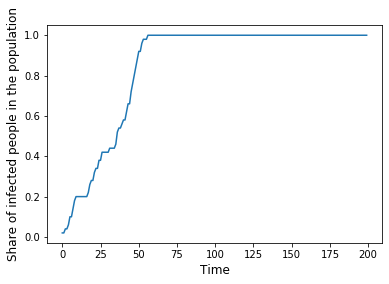

In [19]:
plt.plot(frac_I)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Share of infected people in the population', fontsize=12)

> **Ex. 11.1.6**: Use what you have learned and implement an SIRS model.
* Run it on the Facebook network from last week (so load that into a `networkx.Graph`).
* Record the fraction of infected, susceptiple and recovered over time.
* After the simulation has run, plot these quantities over time and comment on your results
* Be proud of yourself for having solved a really interesting problem.

In [25]:
import json
import pandas as pd

In [36]:
def slice(data, days):
    t_0   =data.timestamp.max()-86400*days
    t_1   =data.timestamp.max()
    data_t=data.loc[data.timestamp.between(t_0,t_1)]
    data_t=data_t.groupby(["user1","user2"]).size().reset_index(name="weight")                   
    
    G_t   =nx.from_pandas_edgelist(data_t,"user1","user2","weight",create_using=nx.Graph)
    return G_t

fb_data = pd.read_csv(
    "facebook-wall.txt",
    delimiter="\t",
    header=None,
    names=['user1', 'user2', 'timestamp']
)

G = slice(fb_data, 7)

In [45]:
#_ = nw.visualize(G) 

#print(fb_data.head())

**When visualising the network, it looks like there are no links - it does not seem to be connected?? This could be the reason why no one is infected?** 

In [39]:
p_I = 0.9 # the probability of catching the diease
p_R = 0.6   # the probability of recovering
p_S = 0.05   # Probability of recovered person becoming susceptible
n_iter = 200 # The number of iterations

I = set() # No one is infected to begin with so the set is empty 
S = set(G.nodes()) # susceptible is set as the nodes from the network G
R = set()

patient0 = np.random.choice(list(S)) # patient 0 is randomly drawn from the susceptible compartment

I.add(patient0) # patient 0 is now in the infected compartment
S.remove(patient0) # patient 0 leaves the susceptible compartment

frac_S = [] 
frac_I = [] 
frac_R = [] 

for t in range(n_iter):
    new_infected = set()

    for infected_node in list(I):
        neighbors = G.neighbors(infected_node) # the neighbors to patient 0 
        infected_neighbors = set([n for n in neighbors if np.random.random() < p_I]) #people getting infected with prob I
        new_infected = new_infected | (infected_neighbors.intersection(S)) 
    
    recovering = set([n for n in list(I) if np.random.random() < p_R]) # people recovering with prob R
    no_immunity = set([n for n in list(R) if np.random.random() < p_S]) # people losing immunity with prob S

    I |= new_infected # entering infected compartment
    I -= recovering # leaving infected because they recover

    S |= no_immunity # entering susceptible compartment
    S -= new_infected # leaving susceptible compartment because they are infected

    R |= recovering # entering recovered compartment
    R -= no_immunity # leaving recovered compartment but back to susceptible compartment because no immunity
     
    frac_I.append(len(I)/len(G.nodes())) # the fraction of infected of the total population in the network
    frac_S.append(len(S)/len(G.nodes())) # the fraction of susceptible of the total population in the network
    frac_R.append(len(R)/len(G.nodes())) # the fraction of recovered of the total population in the network

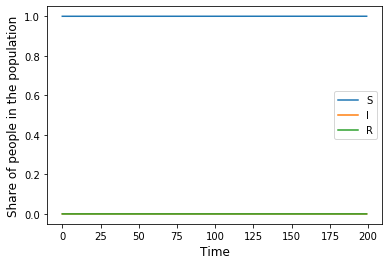

In [40]:
plt.plot(frac_S, label='S')
plt.plot(frac_I, label='I')
plt.plot(frac_R, label='R')
plt.xlabel('Time', fontsize=12)
plt.ylabel('Share of people in the population', fontsize=12)
plt.legend()

**Something is wrong with the graph - no one is getting infected. Perhaps patient zero is not connected to the rest of the population? I've run the code serveral times (to get a new patient zero) and set the probability of getting infected very high. Nothing changes. Must be my fb-network or the code that's wrong. I would like some help/comment on why I can't get it to work, please :-)**

### Further learning

Since the above exercises teaches you how to write down epidemic models (as systems of differential equations)
and subsequently teaches you how to simulate a spreading process on a network to obtain data on infected/susceptible/recovered
over time, you would think it natural that I also taught you how to fit these epidemic models to such data.
This, however, is going a bit too far as this is not a course in computational epidemiology. But if you want to
figure out how to do it, you literally just need to Google search for "fit SIR model".

And finally, a note on how these models are used in the real world. The state-of-the-art in epidemiological modeling is something called "meta popultion models". They are essentially systems of compartmental models. One component in such a model may be a country, and it has its own little SI, SIR or SIRS model. Components are then coupled because there are people moving between them. The paper *The Hidden Geometry of Complex,
Network-Driven Contagion Phenomena* by Dirk Brockmann and Dirk Helbing published in Science in 2013 ([link here](https://www.dropbox.com/s/hxprfyr51fwh907/brockmann13.pdf?dl=0)) sets up such a model for the world using airline traffic as a proxy for people flow between countries. It is a must read if you
are curious about how the pros predict things like when a disease will arrive in a certain place or where a disease originated. I strongly recommend reading it and understanding the figures, it is a stroke of genius.